In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import *

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
pd.set_option('display.max_columns', 500)

# Download census-income dataset

In [26]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'DreamQuarkTabNet'
# out = Path(os.getcwd().rsplit("/",  1)[0]+'/data/'+dataset_name+'.csv')

In [3]:
# out.parent.mkdir(parents=True, exist_ok=True)
# if out.exists():
#     print("File already exists.")
# else:
#     print("Downloading file...")
#     wget.download(url, out.as_posix())

# Load data and split

In [4]:
train = pd.read_csv('data/train_preprocessed.csv', sep='\t')

In [5]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo2Start_Jan,Promo2Start_Feb,Promo2Start_Mar,Promo2Start_Apr,Promo2Start_May,Promo2Start_Jun,Promo2Start_Jul,Promo2Start_Aug,Promo2Start_Sept,Promo2Start_Oct,Promo2Start_Nov,Promo2Start_Dec
0,1,3,2605,327,1,0,1,1,2014,12,31,1,1,570.0,11.0,2007.0,1.0,13.0,2010.0,1,0,0,1,0,0,1,0,0,1,0,0
1,2,3,2269,252,1,0,1,1,2014,12,31,1,1,14130.0,12.0,2006.0,1.0,14.0,2011.0,1,0,0,1,0,0,1,0,0,1,0,0
2,3,3,3804,408,1,0,1,1,2014,12,31,3,3,620.0,9.0,2009.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,3,10152,1311,1,0,1,1,2014,12,31,1,1,29910.0,4.0,2015.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3,1830,217,1,0,1,1,2014,12,31,1,1,310.0,12.0,2013.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
test = pd.read_csv('data/test_preprocessed.csv', sep='\t')
test['Year'] = 2014

In [7]:
target = 'Sales'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [8]:
str_cols = ['Store', 'DayOfWeek', 'Month', 'Day', 'StoreType', 'Assortment', 'StateHoliday']
for col in str_cols:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [9]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    
    if col in test.columns:
        test[col] = l_enc.transform(test[col].values)
    
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    col_mean = train.loc[train_indices, col].mean()
    train.fillna(col_mean, inplace=True)
    test.fillna(col_mean, inplace=True)

Store 1115
DayOfWeek 7
StateHoliday 5
Month 12
Day 31
StoreType 5
Assortment 4
Set 3


# Define categorical features for categorical embeddings

In [10]:
unused_feat = ['Set', 'Year']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [27]:
clf = TabNetRegressor(n_d=64, n_a=64, n_steps=5, gamma=1.5,
                      momentum=0.1, lambda_sparse=1e-5,
                      cat_idxs=cat_idxs, cat_dims=cat_dims)

Device used : cuda


In [28]:
clf

TabNetRegressor(n_d=64, n_a=64, n_steps=5,
                lr=0.02, seed=0,
                gamma=1.5, n_independent=2, n_shared=2,
                cat_idxs=[0, 1, 5, 7, 8, 9, 10],
                cat_dims=[1115, 7, 5, 12, 31, 5, 4],
                cat_emb_dim=1,
                lambda_sparse=1e-05, momentum=0.1,
                clip_value=1,
                verbose=1, device_name="auto",
                model_name="DreamQuarkTabNet_regression",
                optimizer_fn=<class 'torch.optim.adam.Adam'>,
                scheduler_params=None, scheduler_fn=None,
                epsilon=1e-15, saving_path="./")

# Training

In [23]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [24]:
X_true_test = test[features].values
y_true_test = test[target].values

In [25]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=500, patience=50,
    batch_size=8192, virtual_batch_size=256
) 

0it [00:00, ?it/s]

EPOCH : 0


0it [00:00, ?it/s]


ValueError: operands could not be broadcast together with shapes (29,) (57,) (29,) 

In [32]:
clf.batch_size = 8192
clf.best_cost = 0

In [33]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_auc = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {sqrt(test_auc)}")

BEST VALID SCORE FOR DreamQuarkTabNet_regression.pt : 0
FINAL TEST SCORE FOR DreamQuarkTabNet_regression.pt : 353.6176793407061


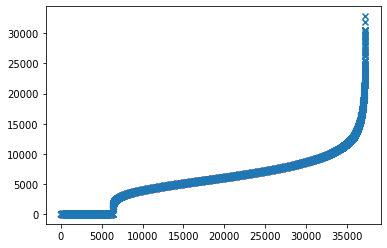

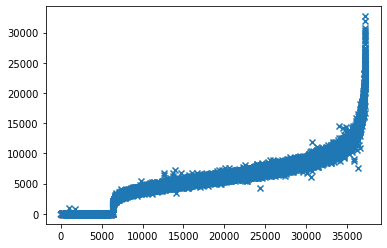

In [34]:
import matplotlib.pyplot as plt
indices_ = np.argsort(y_true)
plt.scatter(range(len(y_true)), y_true[indices_], marker='x')
plt.show()
plt.scatter(range(len(y_true)), preds[indices_], marker='x')
plt.show()

In [35]:
preds = clf.predict(X_true_test)

y_true = y_true_test

test_true_mse = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {sqrt(test_true_mse)}")

BEST VALID SCORE FOR DreamQuarkTabNet_regression.pt : 0
FINAL TEST SCORE FOR DreamQuarkTabNet_regression.pt : 464.6803936180176


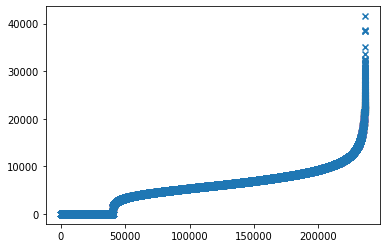

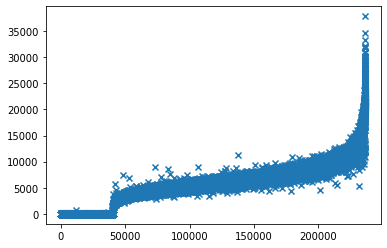

In [18]:
indices_ = np.argsort(y_true)
plt.scatter(range(len(y_true)), y_true[indices_], marker='x')
plt.show()
plt.scatter(range(len(y_true)), preds[indices_], marker='x')
plt.show()

# Global explainability : feat importance summing to 1

In [31]:
id_ = np.argsort(clf.feature_importances_)[::-1]

In [32]:
clf.feature_importances_[id_]

array([4.90059338e-01, 1.95694721e-01, 1.10879462e-01, 5.01211766e-02,
       3.38559316e-02, 2.72523758e-02, 2.19849524e-02, 1.88541231e-02,
       1.34920730e-02, 1.06027552e-02, 9.97226236e-03, 5.39789652e-03,
       3.73783830e-03, 3.46742359e-03, 2.90763291e-03, 1.37836360e-03,
       1.51598556e-04, 9.52553506e-05, 9.48200767e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [34]:
np.array(features)[id_]

array(['Store', 'Promo2Start_Jan', 'DayOfWeek', 'Day', 'Month',
       'Promo2Start_Oct', 'CompetitionOpenSinceMonth', 'StateHoliday',
       'Promo2Start_Jun', 'Promo2SinceYear', 'Promo2Start_Aug',
       'Promo2Start_Feb', 'Customers', 'Promo2Start_Mar',
       'Promo2Start_Dec', 'Promo2', 'Promo2Start_Nov',
       'CompetitionDistance', 'Promo2Start_May',
       'CompetitionOpenSinceYear', 'Assortment', 'StoreType',
       'Promo2SinceWeek', 'Promo2Start_Apr', 'SchoolHoliday', 'Promo',
       'Open', 'Promo2Start_Jul', 'Promo2Start_Sept'], dtype='<U25')

# Local explainability and masks

In [20]:
explain_matrix, masks = clf.explain(X_test)

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

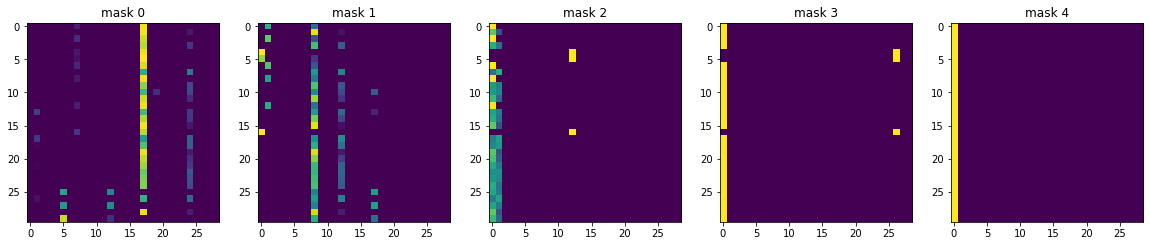

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")


In [23]:
explain_matrix, masks = clf.explain(X_true_test)

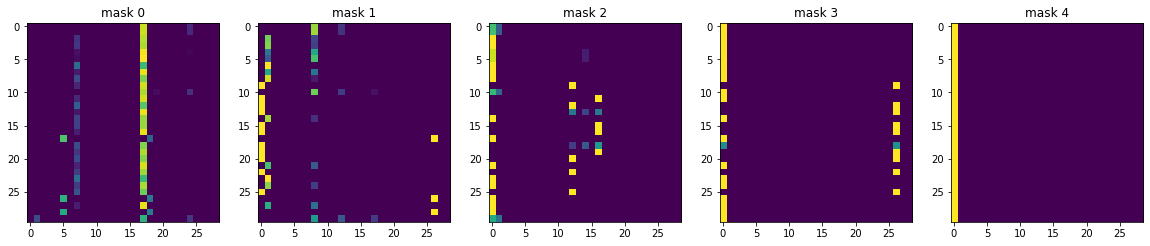

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:30])
    axs[i].set_title(f"mask {i}")


# XGB

In [55]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(
    n_estimators=15000,
    max_depth=7,
    tree_method='gpu_hist',
    colsample_bytree=0.883176060062088,
    reg_alpha=0.14747200224681817,
    silent=1,
    eval_metric='rmse',
    grow_policy='depthwise',
    learning_rate=0.10032091014826115,
    subsample=0.5740170782945163,
    reg_lambda=0, max_bin=1020,
    objective='reg:linear',
    min_split_loss=0,
    
)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=500,
        verbose=10)

[0]	validation_0-rmse:6301.23
Will train until validation_0-rmse hasn't improved in 500 rounds.
[10]	validation_0-rmse:2491.13
[20]	validation_0-rmse:1428.42
[30]	validation_0-rmse:1162.48
[40]	validation_0-rmse:1077.91
[50]	validation_0-rmse:1017.21
[60]	validation_0-rmse:957.002
[70]	validation_0-rmse:891.711
[80]	validation_0-rmse:857.016
[90]	validation_0-rmse:809.272
[100]	validation_0-rmse:769.913
[110]	validation_0-rmse:740.057
[120]	validation_0-rmse:701.045
[130]	validation_0-rmse:675.466
[140]	validation_0-rmse:661.697
[150]	validation_0-rmse:645.231
[160]	validation_0-rmse:622.3
[170]	validation_0-rmse:607.453
[180]	validation_0-rmse:592.683
[190]	validation_0-rmse:577.655
[200]	validation_0-rmse:562.894
[210]	validation_0-rmse:552.105
[220]	validation_0-rmse:539.922
[230]	validation_0-rmse:533.442
[240]	validation_0-rmse:522.602
[250]	validation_0-rmse:515.743
[260]	validation_0-rmse:507.488
[270]	validation_0-rmse:498.111
[280]	validation_0-rmse:491.073
[290]	validation_0-

[2510]	validation_0-rmse:348.726
[2520]	validation_0-rmse:348.712
[2530]	validation_0-rmse:348.611
[2540]	validation_0-rmse:348.568
[2550]	validation_0-rmse:348.52
[2560]	validation_0-rmse:348.481
[2570]	validation_0-rmse:348.449
[2580]	validation_0-rmse:348.429
[2590]	validation_0-rmse:348.358
[2600]	validation_0-rmse:348.343
[2610]	validation_0-rmse:348.32
[2620]	validation_0-rmse:348.337
[2630]	validation_0-rmse:348.262
[2640]	validation_0-rmse:348.229
[2650]	validation_0-rmse:348.177
[2660]	validation_0-rmse:348.101
[2670]	validation_0-rmse:348.026
[2680]	validation_0-rmse:347.936
[2690]	validation_0-rmse:347.921
[2700]	validation_0-rmse:347.884
[2710]	validation_0-rmse:347.82
[2720]	validation_0-rmse:347.781
[2730]	validation_0-rmse:347.642
[2740]	validation_0-rmse:347.574
[2750]	validation_0-rmse:347.565
[2760]	validation_0-rmse:347.53
[2770]	validation_0-rmse:347.458
[2780]	validation_0-rmse:347.437
[2790]	validation_0-rmse:347.397
[2800]	validation_0-rmse:347.377
[2810]	validat

[5010]	validation_0-rmse:345.535
[5020]	validation_0-rmse:345.572
[5030]	validation_0-rmse:345.577
[5040]	validation_0-rmse:345.579
[5050]	validation_0-rmse:345.573
[5060]	validation_0-rmse:345.559
[5070]	validation_0-rmse:345.582
[5080]	validation_0-rmse:345.6
[5090]	validation_0-rmse:345.575
[5100]	validation_0-rmse:345.594
[5110]	validation_0-rmse:345.577
[5120]	validation_0-rmse:345.584
[5130]	validation_0-rmse:345.604
[5140]	validation_0-rmse:345.639
[5150]	validation_0-rmse:345.646
[5160]	validation_0-rmse:345.654
[5170]	validation_0-rmse:345.646
[5180]	validation_0-rmse:345.657
[5190]	validation_0-rmse:345.689
[5200]	validation_0-rmse:345.682
[5210]	validation_0-rmse:345.701
[5220]	validation_0-rmse:345.699
[5230]	validation_0-rmse:345.69
[5240]	validation_0-rmse:345.693
[5250]	validation_0-rmse:345.682
[5260]	validation_0-rmse:345.661
[5270]	validation_0-rmse:345.653
[5280]	validation_0-rmse:345.646
[5290]	validation_0-rmse:345.633
[5300]	validation_0-rmse:345.642
[5310]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.883176060062088,
             eval_metric='rmse', gamma=0, grow_policy='depthwise',
             importance_type='gain', learning_rate=0.10032091014826115,
             max_bin=1020, max_delta_step=0, max_depth=7, min_child_weight=1,
             min_split_loss=0, missing=None, n_estimators=15000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.14747200224681817, reg_lambda=0, scale_pos_weight=1,
             seed=None, silent=1, subsample=0.5740170782945163,
             tree_method='gpu_hist', verbosity=1)

In [56]:
clf_xgb.feature_importances_

array([0.01891081, 0.01768534, 0.29396632, 0.07115039, 0.10092605,
       0.01145023, 0.00470017, 0.00729083, 0.00479908, 0.02984716,
       0.0171219 , 0.02288054, 0.01960108, 0.01961047, 0.04267998,
       0.01750463, 0.02538559, 0.01273111, 0.01663766, 0.01301947,
       0.05034421, 0.02561332, 0.01006061, 0.01048246, 0.04214257,
       0.02053112, 0.05443379, 0.01583528, 0.00265781], dtype=float32)

In [57]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(sqrt(valid_auc))

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(sqrt(test_auc))

345.36189850863315
349.844745539146


In [58]:
preds = np.array(clf_xgb.predict(X_true_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_true_test)
print(sqrt(test_auc))

486.8043487855505
